### Welcome!

This is another notebook demonstration the extraction method from our [ICML 2018 paper](https://arxiv.org/abs/1711.09576), only with a little extra functionality to help you keep track of multiple networks, and without documentation.

In [1]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNClassifier import RNNClassifier
from Training_Functions import mixed_curriculum_train
from Tomita_Grammars import tomita_1, tomita_2, tomita_3, tomita_4, tomita_5, tomita_6, tomita_7
from Training_Functions import make_train_set_for_target
from Extraction import extract

In [2]:
try:
    None == all_my_rnns
except NameError:
    all_my_rnns = []
    
class Wrapper:
    def __init__(self,rnn,alphabet,target,name,train_set):
        self.rnn = rnn
        self.alphabet = alphabet
        self.target = target
        self.name = name
        words = sorted(list(train_set.keys()),key=lambda x:len(x))
        short_pos = next((w for w in words if target(w)==True),None)
        short_neg = next((w for w in words if target(w)==False),None)
        self.starting_examples = [w for w in [short_pos,short_neg] if not None==w]
        self.train_set = train_set
        self.dfas = []
    def __repr__(self):
        return self.name

In [3]:
alphabet = "01"
target = tomita_3
name = "my Tomita 3 RNN"

# alternative option (example):
# def target(w):
#     if len(w)==0:
#         return True
#     return w[0]==w[-1]
# alphabet = "abc"
# name = "start and end same over abc"


rnn = RNNClassifier(alphabet,num_layers=1,hidden_dim=10,RNNClass = LSTMNetwork)


train_set = make_train_set_for_target(target,alphabet)
wrapper = Wrapper(rnn,alphabet,target,name,train_set)
all_my_rnns.append(wrapper)

made train set of size: 2731 , of which positive examples: 1308


current average loss is:  0.0054309656350380875


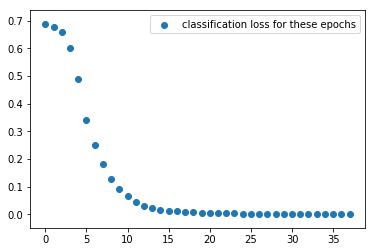

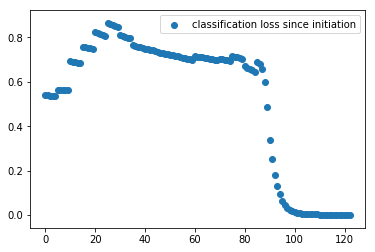

classification loss on last batch was: 0.0004836621741852622


In [4]:
mixed_curriculum_train(wrapper.rnn,wrapper.train_set,stop_threshold = 0.0005)

In [5]:
wrapper.rnn.renew()  
# you only really need this if you start messing about and doing weird stuff. 
# It cleans the computation graph, but doesn't reset the weights so don't worry

provided counterexamples are: ['', '10']
obs table refinement took 0.0
guided starting equivalence query for DFA of size 1


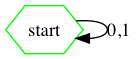

storing provided counterexample of length 2
returning counterexample of length 2:		10, this counterexample is rejected by the given RNN.
equivalence checking took: 0.017189000000001897
obs table refinement took 0.002
guided starting equivalence query for DFA of size 4


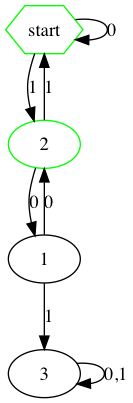

split wasn't perfect: gotta start over
returning counterexample of length 5:		10010, this counterexample is rejected by the given RNN.
equivalence checking took: 0.08149300000000892
obs table refinement took 0.003
guided starting equivalence query for DFA of size 5


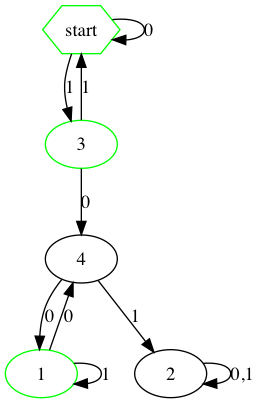

lstar successful: unrolling seems equivalent to proposed automaton
equivalence checking took: 0.017006999999992445
overall guided extraction time took: 0.12463400000000036
generated counterexamples were: (format: (counterexample, counterexample generation time))
('10', 0.017189000000001897)
('10010', 0.08149300000000892)


In [6]:
wrapper.dfas.append(
    extract(wrapper.rnn,time_limit=50,initial_split_depth=10,starting_examples=wrapper.starting_examples))

testing on train set, i.e. test set is train set


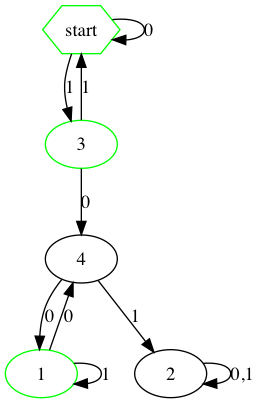

current test set size: 2731
of which positive: 1308 (47.89%)
rnn score against target on test set: 2731 (100.0%)
extracted dfa score against rnn on test set: 2731 (100.0%)
extracted dfa score against target on test set: 2731 (100.0%)


In [7]:
wrapper = all_my_rnns[-1]
wrapper.rnn.renew()
dfa_index = -1 # if you want to check the DFA from the last time you extracted something for this network
dfa = wrapper.dfas[-1]
test_set = wrapper.train_set 
print("testing on train set, i.e. test set is train set")
# here we're printing things on the train set, but you can also try other sets if you like
# for instance you could also make one by running make_train_set_for_target(wrapper.target,wrapper.alphabet)


from math import pow
def percent(num,digits=2):
    tens = pow(10,digits)
    return str(int(100*num*tens)/tens)+"%"

dfa.draw_nicely(maximum=30) #max size willing to draw
n = len(test_set)
print("current test set size:", n)
pos = len([w for w in test_set if wrapper.target(w)])
print("of which positive:",pos,"("+percent(pos/n)+")")
rnn_target = len([w for w in test_set if wrapper.rnn.classify_word(w)==wrapper.target(w)])
print("rnn score against target on test set:",rnn_target,"("+percent(rnn_target/n)+")")
dfa_rnn = len([w for w in test_set if wrapper.rnn.classify_word(w)==dfa.classify_word(w)])
print("extracted dfa score against rnn on test set:",dfa_rnn,"("+percent(dfa_rnn/n)+")")
dfa_target = len([w for w in test_set if dfa.classify_word(w)==wrapper.target(w)])
print("extracted dfa score against target on test set:",dfa_target,"("+percent(dfa_target/n)+")")